## 1: GHZ state with and without dynamic programming

### Reference: Efficient Long-Range Entanglement using Dynamic Circuits at https://arxiv.org/abs/2308.13065

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
import numpy as np

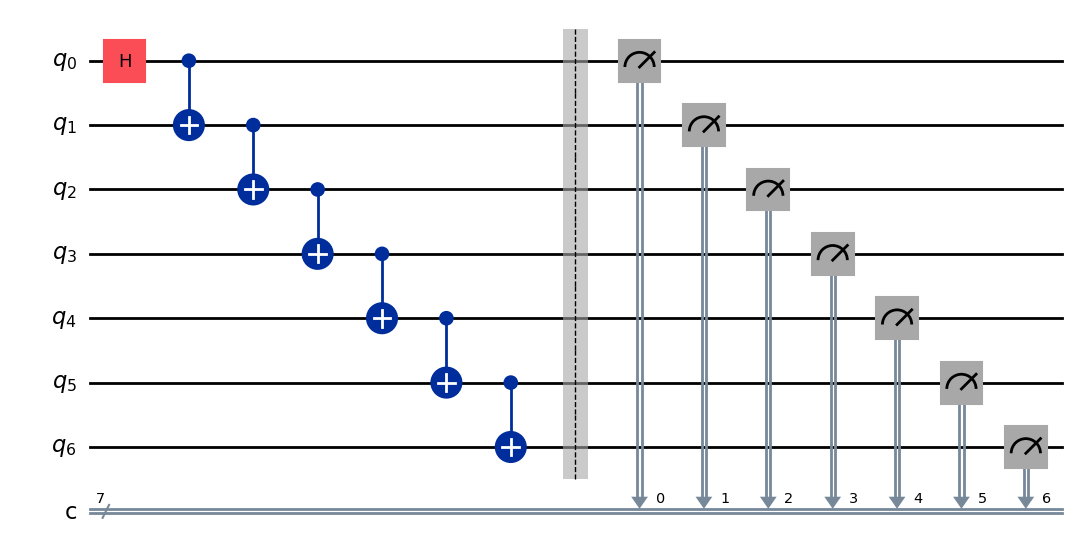

In [3]:
direct_circuit = QuantumCircuit(7, 7)

direct_circuit.h(0)
direct_circuit.cx(0, 1)
direct_circuit.cx(1, 2)
direct_circuit.cx(2, 3)
direct_circuit.cx(3, 4)
direct_circuit.cx(4, 5)
direct_circuit.cx(5, 6)
direct_circuit.barrier()
direct_circuit.measure(list(range(7)), list(range(7)))

direct_circuit.draw('mpl')

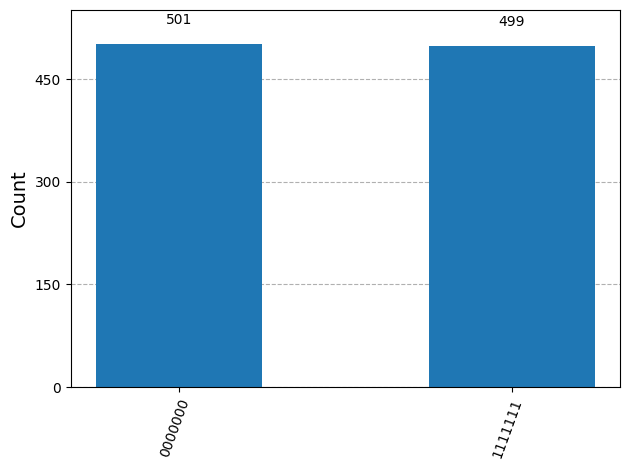

In [6]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
backend = AerSimulator()
sampler = Sampler(backend)
direct_circuit = transpile(direct_circuit, backend=backend)
result = sampler.run([direct_circuit], shots=1000).result()
plot_histogram(result[0].data.c.get_counts())
# print('result: ', result[0].data.c2.get_counts())

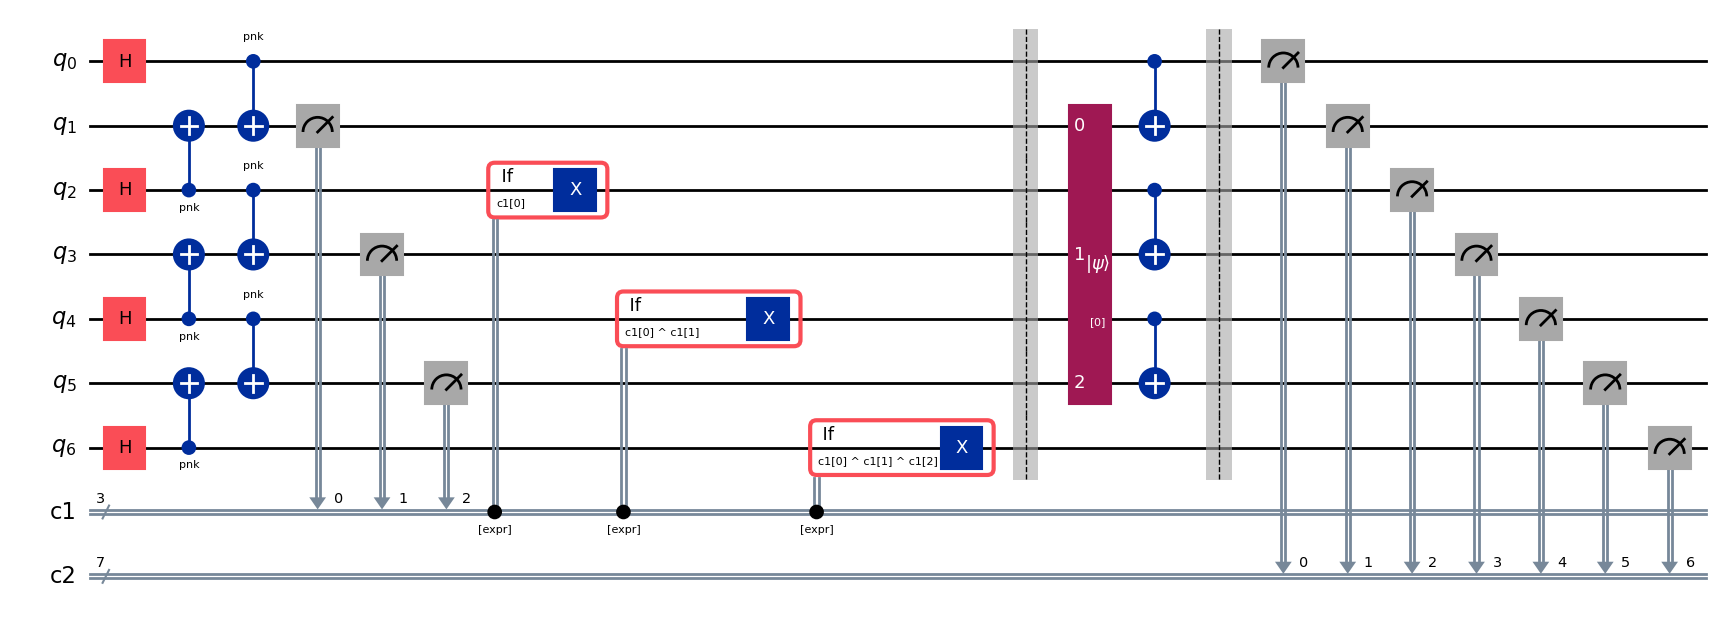

In [7]:
from qiskit.circuit.classical import expr

q = QuantumRegister(7, 'q')
c1 = ClassicalRegister(3, 'c1')
c2 = ClassicalRegister(7, 'c2')
circuit2 = QuantumCircuit(q, c1, c2)

circuit2.h([0, 2, 4, 6])
circuit2.cx(2, 1, 'pnk')
circuit2.cx(4, 3, 'pnk')
circuit2.cx(6, 5, 'pnk')
circuit2.cx(0, 1, 'pnk')
circuit2.cx(2, 3, 'pnk')
circuit2.cx(4, 5, 'pnk')
circuit2.measure([1, 3, 5], c1)

with circuit2.if_test(expr.lift(c1[0])):
    circuit2.x(2)

with circuit2.if_test(expr.bit_xor(c1[0], c1[1])):
    circuit2.x(4)

c1_c2_xor = expr.bit_xor(c1[0], c1[1])
with circuit2.if_test(expr.bit_xor(c1_c2_xor, c1[2])):    
    circuit2.x(6)

circuit2.barrier()
circuit2.initialize(0, [1, 3, 5])

circuit2.cx(0, 1)
circuit2.cx(2, 3)
circuit2.cx(4, 5)

circuit2.barrier()
circuit2.measure(q, c2)

circuit2.draw('mpl')

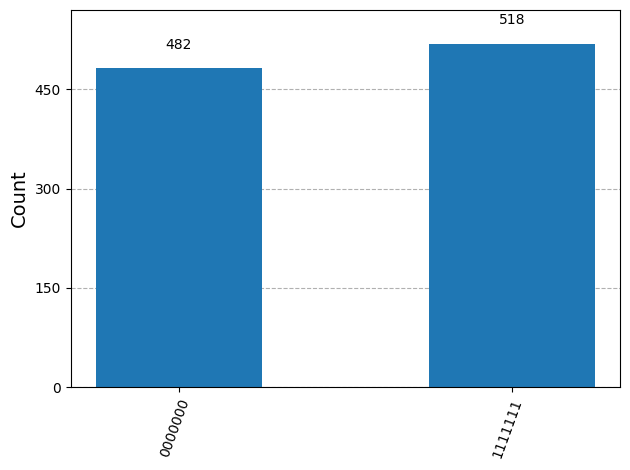

In [8]:
backend = AerSimulator()
sampler = Sampler(backend)
circuit2_tp = transpile(circuit2, backend=backend)
result = sampler.run([circuit2_tp], shots=1000).result()
plot_histogram(result[0].data.c2.get_counts())
# print('result: ', result[0].data.c2.get_counts())

## 2: State teleportation across four qubits using dynamic programming

### Reference: Efficient Long-Range Entanglement using Dynamic Circuits at https://arxiv.org/abs/2308.13065

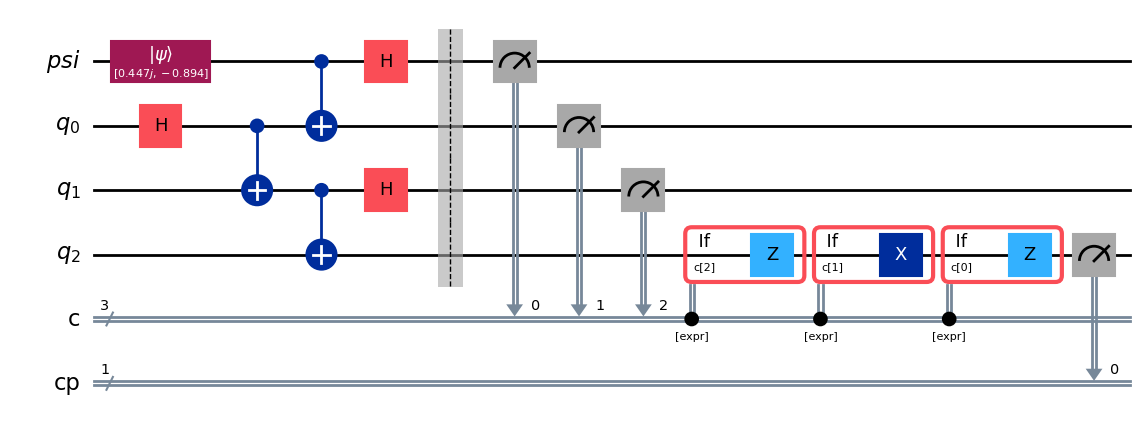

In [10]:
from qiskit import quantum_info
input_psi = quantum_info.Statevector(np.sqrt(0.2)*np.array([1j, 0])) - quantum_info.Statevector(np.sqrt(0.8)*np.array([0, 1]))
# input_psi = quantum_info.Statevector(np.array([np.sqrt(0.2)*1j, np.sqrt(0.8)]))
# input_psi.draw('latex')

def teleportation():
    psi_circuit = QuantumRegister(1, name='psi')
    q_circuit = QuantumRegister(3, name='q')
    cls = ClassicalRegister(3, name='c')
    cls_phi = ClassicalRegister(1, name='cp')

    circuit = QuantumCircuit(psi_circuit, q_circuit, cls, cls_phi)

    circuit.initialize(input_psi, 0)

    circuit.h(1)
    circuit.cx(1,2)

    circuit.cx([0, 2], [1, 3])
    # circuit.cx(2, 3)

    circuit.h([0, 2])
    circuit.barrier()
    circuit.measure([0, 1, 2], [0, 1, 2])

    with circuit.if_test(expr.lift(cls[2])):
        circuit.z(3)

    with circuit.if_test(expr.lift(cls[1])):
        circuit.x(3)

    with circuit.if_test(expr.lift(cls[0])):
        circuit.z(3)

    circuit.measure(3, 3)

    return circuit

telep_circuit = teleportation()
telep_circuit.draw('mpl')

Output state: sqrt(0.21)|0> + sqrt(0.79)|1>


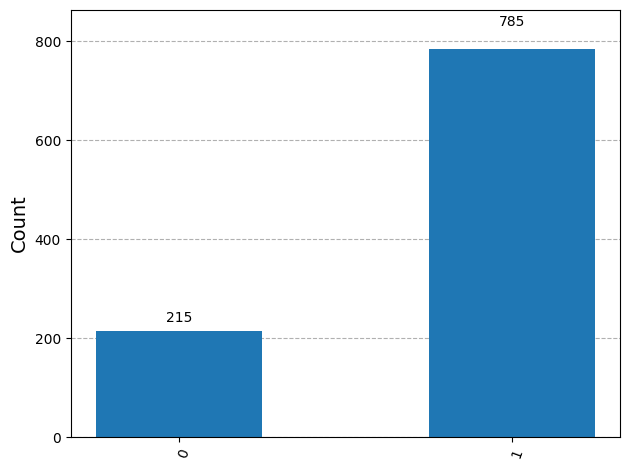

In [11]:
aer_sim = AerSimulator()
telep_circuit = transpile(telep_circuit, backend=aer_sim)

sampler = Sampler(aer_sim)

total_shots = 1000
result = sampler.run([telep_circuit], shots=total_shots).result()

stats = result[0].data.cp.get_counts()

prob_0 = stats['0']/total_shots
prob_1 = stats['1']/total_shots

print(f'Output state: sqrt({prob_0:.02f})|0> + sqrt({prob_1:.02f})|1>')

plot_histogram(stats)